## Data Cleansing

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import time
import tensorflow as tf
from keras.utils import np_utils
import cv2 as cv
import os

C:\Users\hasee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv("../BIA662_Image_recognization/train_ship_segmentations_v2.csv", sep= ',')

In [4]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
df.shape

(231723, 2)

#### traning testing

In [5]:
images = os.listdir('../BIA662_Image_recognization/train_new/')

abc=[]
for i,v in enumerate(images):
    vv = v.split(',')[0]
    abc.append(vv)


final_1=[]
for a,b in enumerate(abc):
    if b[0] != '.':
        final_1.append(b)
print(len(final_1))

14710


In [6]:
images = os.listdir('../BIA662_Image_recognization/test/')

abc=[]
for i,v in enumerate(images):
    vv = v.split(',')[0]
    abc.append(vv)
#print(abc)

final_2=[]
for a,b in enumerate(abc):
    if b[0] != '.':
        final_2.append(b)
print(len(final_2))

4185


In [7]:
final_3 = final_1 + final_2
print(len(final_3))

18895


In [8]:
#aaa = df[0:20]
df2 = df.copy()
df2.shape
#aaa.shape

(231723, 2)

In [9]:
xxx = df2.sample(18895)
xxx.shape
xxx.head()

,ImageId,EncodedPixels
31020,228ac4441.jpg,NaN
145728,a0d32bf20.jpg,NaN
228348,fc2e349b8.jpg,NaN
23611,1a383decd.jpg,441666 2 442434 5 443201 8 443969 10 444736 11...
174335,c0a4563da.jpg,NaN


In [10]:
xxx['EncodedPixels'] = xxx['EncodedPixels'].fillna(0)

In [11]:
xxx.loc[xxx['EncodedPixels'] != 0 , 'EncodedPixels'] = 1

In [12]:
xxx = xxx.rename(columns={'ImageId': 'Image',
                        'EncodedPixels': 'Existing'})
xxx.head()

,Image,Existing
31020,228ac4441.jpg,0
145728,a0d32bf20.jpg,0
228348,fc2e349b8.jpg,0
23611,1a383decd.jpg,1
174335,c0a4563da.jpg,0


In [13]:
xxx['Existing'].value_counts()

0    12250
1     6645
Name: Existing, dtype: int64

In [14]:
# Ratio of finding ships
xxx['Existing'].value_counts()[1] / xxx['Existing'].count()

0.3516803387139455

In [15]:
xxx['Image'] = final_3

In [16]:
xxx.tail()

,Image,Existing
177016,9fe789a55.jpg,0
57855,9fe817c74.jpg,1
166755,9fef2b1cb.jpg,1
104898,9ff11a9f9.jpg,0
22982,9ff13b98b.jpg,1


In [16]:
# divide into 80% train and 20% test
new_sample = int(xxx['Image'].count() *0.4)
train_sample = int(new_sample * 0.8)
test_sample = new_sample - train_sample

new_sample, train_sample, test_sample

(7558, 6046, 1512)

In [17]:
xxx_train = xxx.sample(train_sample)
xxx_test = xxx.sample(test_sample)

In [18]:
#import tensorflow as tf
train_path = '../BIA662_Image_recognization/train_new/'
test_path = '../BIA662_Image_recognization/test/'

In [19]:
# define function to load data
def load_data(path,cat):
    file = []
    
    if str(path) == str(train_path):  
        data = np.array(xxx_train['Image'])
        targets = np_utils.to_categorical(np.array(xxx_train['Existing']),cat)
        
        for i,v in enumerate(data):
            file.append(train_path + v)       
        data = np.array(file)
    
    else:    
        data = np.array(xxx_test['Image'])
        targets = np_utils.to_categorical(np.array(xxx_test['Existing']),cat)
        
        for i,v in enumerate(data):
            file.append(train_path + v)  
        data = np.array(file)
        
    return data, targets

In [20]:
from keras.preprocessing import image
from tqdm import tqdm

def image_to_tensor(image_path):
    img = image.load_img(image_path, target_size=(224,224))
    
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def path_to_tensor(image_paths):
    list_tensors = [image_to_tensor(image_path) for image_path in tqdm(image_paths)]
    return np.vstack(list_tensors) 
    

In [21]:
import numpy as np
import pandas as pd
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from PIL import ImageFile

In [22]:
ImageFile.LOAD_TRUNCATED_IMAGE = True

test_files, test_targets = load_data(test_path,20)
test_tensors = path_to_tensor(test_files).astype('float32')/255
    
train_files, train_targets = load_data(train_path,20)
train_tensors = path_to_tensor(train_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████| 6046/6046 [01:09<00:00, 86.58it/s]


## Modeling

In [24]:
model = Sequential()

# CNN first layer
model.add(Conv2D(filters=16,
                 kernel_size=2,
                 padding='same',
                 input_shape=(224,224,3), 
                 activation='relu'))
# CNN second layer
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,
                 kernel_size=2,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(20,activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

In [25]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

In [26]:
#model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
modelcp = keras.callbacks.ModelCheckpoint("../BIA662/test5.hdf5",
                                          save_best_only = True)
# training data
train_history=model.fit(train_tensors, train_targets,
                        validation_data = (test_tensors, test_targets), 
                        epochs=20, batch_size=20, callbacks=[modelcp])

Train on 6046 samples, validate on 1512 samples
Epoch 1/20
4060/6046 [===================>..........] - ETA: 8:39 - loss: 0.1987 - acc: 0.950 - ETA: 5:57 - loss: 0.2558 - acc: 0.965 - ETA: 5:04 - loss: 0.2558 - acc: 0.967 - ETA: 4:36 - loss: 0.2344 - acc: 0.959 - ETA: 4:19 - loss: 0.2055 - acc: 0.963 - ETA: 4:08 - loss: 0.2107 - acc: 0.963 - ETA: 4:00 - loss: 0.1949 - acc: 0.961 - ETA: 3:53 - loss: 0.1794 - acc: 0.962 - ETA: 3:48 - loss: 0.1673 - acc: 0.962 - ETA: 3:44 - loss: 0.1667 - acc: 0.960 - ETA: 3:40 - loss: 0.1599 - acc: 0.958 - ETA: 3:38 - loss: 0.1535 - acc: 0.957 - ETA: 3:36 - loss: 0.1488 - acc: 0.957 - ETA: 3:33 - loss: 0.1440 - acc: 0.956 - ETA: 3:31 - loss: 0.1395 - acc: 0.955 - ETA: 3:29 - loss: 0.1340 - acc: 0.957 - ETA: 3:27 - loss: 0.1294 - acc: 0.958 - ETA: 3:26 - loss: 0.1265 - acc: 0.958 - ETA: 3:24 - loss: 0.1232 - acc: 0.959 - ETA: 3:23 - loss: 0.1202 - acc: 0.959 - ETA: 3:21 - loss: 0.1181 - acc: 0.959 - ETA: 3:20 - loss: 0.1164 - acc: 0.958 - ETA: 3:18 - loss

4080/6046 [===================>..........] - ETA: 3:17 - loss: 0.0720 - acc: 0.950 - ETA: 3:17 - loss: 0.0694 - acc: 0.960 - ETA: 3:16 - loss: 0.0691 - acc: 0.958 - ETA: 3:16 - loss: 0.0680 - acc: 0.961 - ETA: 3:15 - loss: 0.0681 - acc: 0.961 - ETA: 3:15 - loss: 0.0672 - acc: 0.962 - ETA: 3:15 - loss: 0.0687 - acc: 0.960 - ETA: 3:14 - loss: 0.0687 - acc: 0.960 - ETA: 3:13 - loss: 0.0691 - acc: 0.959 - ETA: 3:12 - loss: 0.0688 - acc: 0.959 - ETA: 3:12 - loss: 0.0686 - acc: 0.960 - ETA: 3:11 - loss: 0.0676 - acc: 0.962 - ETA: 3:11 - loss: 0.0683 - acc: 0.961 - ETA: 3:10 - loss: 0.0679 - acc: 0.962 - ETA: 3:09 - loss: 0.0669 - acc: 0.963 - ETA: 3:09 - loss: 0.0668 - acc: 0.964 - ETA: 3:08 - loss: 0.0663 - acc: 0.964 - ETA: 3:08 - loss: 0.0663 - acc: 0.964 - ETA: 3:07 - loss: 0.0659 - acc: 0.965 - ETA: 3:06 - loss: 0.0658 - acc: 0.965 - ETA: 3:06 - loss: 0.0647 - acc: 0.966 - ETA: 3:06 - loss: 0.0651 - acc: 0.966 - ETA: 3:05 - loss: 0.0652 - acc: 0.966 - ETA: 3:05 - loss: 0.0654 - acc: 0.9

6046/6046 [==============================] - ETA: 1:06 - loss: 0.0662 - acc: 0.965 - ETA: 1:05 - loss: 0.0662 - acc: 0.965 - ETA: 1:04 - loss: 0.0662 - acc: 0.965 - ETA: 1:04 - loss: 0.0662 - acc: 0.965 - ETA: 1:03 - loss: 0.0662 - acc: 0.965 - ETA: 1:02 - loss: 0.0662 - acc: 0.965 - ETA: 1:02 - loss: 0.0662 - acc: 0.965 - ETA: 1:01 - loss: 0.0662 - acc: 0.965 - ETA: 1:00 - loss: 0.0661 - acc: 0.965 - ETA: 1:00 - loss: 0.0661 - acc: 0.965 - ETA: 59s - loss: 0.0662 - acc: 0.965 - ETA: 58s - loss: 0.0662 - acc: 0.96 - ETA: 57s - loss: 0.0662 - acc: 0.96 - ETA: 57s - loss: 0.0662 - acc: 0.96 - ETA: 56s - loss: 0.0662 - acc: 0.96 - ETA: 55s - loss: 0.0662 - acc: 0.96 - ETA: 55s - loss: 0.0662 - acc: 0.96 - ETA: 54s - loss: 0.0662 - acc: 0.96 - ETA: 53s - loss: 0.0662 - acc: 0.96 - ETA: 53s - loss: 0.0662 - acc: 0.96 - ETA: 52s - loss: 0.0661 - acc: 0.96 - ETA: 51s - loss: 0.0663 - acc: 0.96 - ETA: 51s - loss: 0.0663 - acc: 0.96 - ETA: 50s - loss: 0.0662 - acc: 0.96 - ETA: 49s - loss: 0.066

4080/6046 [===================>..........] - ETA: 3:08 - loss: 0.0674 - acc: 0.960 - ETA: 3:12 - loss: 0.0683 - acc: 0.957 - ETA: 3:11 - loss: 0.0699 - acc: 0.955 - ETA: 3:11 - loss: 0.0698 - acc: 0.955 - ETA: 3:12 - loss: 0.0689 - acc: 0.957 - ETA: 3:13 - loss: 0.0672 - acc: 0.960 - ETA: 3:14 - loss: 0.0662 - acc: 0.962 - ETA: 3:14 - loss: 0.0661 - acc: 0.963 - ETA: 3:14 - loss: 0.0649 - acc: 0.965 - ETA: 3:14 - loss: 0.0650 - acc: 0.965 - ETA: 3:14 - loss: 0.0657 - acc: 0.964 - ETA: 3:14 - loss: 0.0656 - acc: 0.964 - ETA: 3:14 - loss: 0.0655 - acc: 0.964 - ETA: 3:14 - loss: 0.0649 - acc: 0.965 - ETA: 3:13 - loss: 0.0648 - acc: 0.965 - ETA: 3:13 - loss: 0.0655 - acc: 0.964 - ETA: 3:12 - loss: 0.0659 - acc: 0.963 - ETA: 3:12 - loss: 0.0660 - acc: 0.963 - ETA: 3:11 - loss: 0.0662 - acc: 0.962 - ETA: 3:10 - loss: 0.0659 - acc: 0.963 - ETA: 3:09 - loss: 0.0663 - acc: 0.962 - ETA: 3:08 - loss: 0.0664 - acc: 0.962 - ETA: 3:07 - loss: 0.0662 - acc: 0.963 - ETA: 3:06 - loss: 0.0663 - acc: 0.9

6046/6046 [==============================] - ETA: 1:03 - loss: 0.0660 - acc: 0.964 - ETA: 1:03 - loss: 0.0660 - acc: 0.964 - ETA: 1:02 - loss: 0.0660 - acc: 0.964 - ETA: 1:01 - loss: 0.0660 - acc: 0.964 - ETA: 1:01 - loss: 0.0660 - acc: 0.964 - ETA: 1:00 - loss: 0.0660 - acc: 0.964 - ETA: 59s - loss: 0.0660 - acc: 0.964 - ETA: 59s - loss: 0.0660 - acc: 0.96 - ETA: 58s - loss: 0.0660 - acc: 0.96 - ETA: 57s - loss: 0.0660 - acc: 0.96 - ETA: 57s - loss: 0.0659 - acc: 0.96 - ETA: 56s - loss: 0.0659 - acc: 0.96 - ETA: 55s - loss: 0.0659 - acc: 0.96 - ETA: 55s - loss: 0.0658 - acc: 0.96 - ETA: 54s - loss: 0.0659 - acc: 0.96 - ETA: 53s - loss: 0.0659 - acc: 0.96 - ETA: 53s - loss: 0.0659 - acc: 0.96 - ETA: 52s - loss: 0.0659 - acc: 0.96 - ETA: 51s - loss: 0.0658 - acc: 0.96 - ETA: 51s - loss: 0.0658 - acc: 0.96 - ETA: 50s - loss: 0.0658 - acc: 0.96 - ETA: 50s - loss: 0.0659 - acc: 0.96 - ETA: 49s - loss: 0.0658 - acc: 0.96 - ETA: 48s - loss: 0.0658 - acc: 0.96 - ETA: 48s - loss: 0.0659 - acc:

4080/6046 [===================>..........] - ETA: 3:13 - loss: 0.0642 - acc: 0.970 - ETA: 3:15 - loss: 0.0660 - acc: 0.965 - ETA: 3:16 - loss: 0.0611 - acc: 0.973 - ETA: 3:16 - loss: 0.0616 - acc: 0.971 - ETA: 3:15 - loss: 0.0621 - acc: 0.970 - ETA: 3:14 - loss: 0.0627 - acc: 0.967 - ETA: 3:14 - loss: 0.0626 - acc: 0.967 - ETA: 3:12 - loss: 0.0625 - acc: 0.967 - ETA: 3:12 - loss: 0.0624 - acc: 0.967 - ETA: 3:11 - loss: 0.0627 - acc: 0.966 - ETA: 3:10 - loss: 0.0628 - acc: 0.965 - ETA: 3:10 - loss: 0.0640 - acc: 0.963 - ETA: 3:09 - loss: 0.0639 - acc: 0.963 - ETA: 3:08 - loss: 0.0636 - acc: 0.964 - ETA: 3:08 - loss: 0.0634 - acc: 0.964 - ETA: 3:07 - loss: 0.0629 - acc: 0.965 - ETA: 3:06 - loss: 0.0631 - acc: 0.965 - ETA: 3:06 - loss: 0.0637 - acc: 0.964 - ETA: 3:05 - loss: 0.0637 - acc: 0.964 - ETA: 3:05 - loss: 0.0642 - acc: 0.963 - ETA: 3:04 - loss: 0.0639 - acc: 0.964 - ETA: 3:04 - loss: 0.0637 - acc: 0.964 - ETA: 3:03 - loss: 0.0642 - acc: 0.964 - ETA: 3:02 - loss: 0.0643 - acc: 0.9

6046/6046 [==============================] - ETA: 1:03 - loss: 0.0636 - acc: 0.966 - ETA: 1:03 - loss: 0.0636 - acc: 0.966 - ETA: 1:02 - loss: 0.0636 - acc: 0.966 - ETA: 1:01 - loss: 0.0635 - acc: 0.966 - ETA: 1:01 - loss: 0.0635 - acc: 0.966 - ETA: 1:00 - loss: 0.0634 - acc: 0.966 - ETA: 59s - loss: 0.0635 - acc: 0.966 - ETA: 59s - loss: 0.0635 - acc: 0.96 - ETA: 58s - loss: 0.0635 - acc: 0.96 - ETA: 57s - loss: 0.0635 - acc: 0.96 - ETA: 57s - loss: 0.0635 - acc: 0.96 - ETA: 56s - loss: 0.0635 - acc: 0.96 - ETA: 55s - loss: 0.0635 - acc: 0.96 - ETA: 55s - loss: 0.0636 - acc: 0.96 - ETA: 54s - loss: 0.0636 - acc: 0.96 - ETA: 53s - loss: 0.0636 - acc: 0.96 - ETA: 53s - loss: 0.0635 - acc: 0.96 - ETA: 52s - loss: 0.0635 - acc: 0.96 - ETA: 51s - loss: 0.0634 - acc: 0.96 - ETA: 51s - loss: 0.0634 - acc: 0.96 - ETA: 50s - loss: 0.0636 - acc: 0.96 - ETA: 49s - loss: 0.0635 - acc: 0.96 - ETA: 49s - loss: 0.0635 - acc: 0.96 - ETA: 48s - loss: 0.0635 - acc: 0.96 - ETA: 47s - loss: 0.0635 - acc:

4080/6046 [===================>..........] - ETA: 3:08 - loss: 0.0585 - acc: 0.975 - ETA: 3:07 - loss: 0.0564 - acc: 0.970 - ETA: 3:07 - loss: 0.0544 - acc: 0.971 - ETA: 3:08 - loss: 0.0574 - acc: 0.970 - ETA: 3:08 - loss: 0.0539 - acc: 0.974 - ETA: 3:07 - loss: 0.0557 - acc: 0.971 - ETA: 3:07 - loss: 0.0541 - acc: 0.972 - ETA: 3:06 - loss: 0.0562 - acc: 0.970 - ETA: 3:07 - loss: 0.0551 - acc: 0.971 - ETA: 3:06 - loss: 0.0551 - acc: 0.971 - ETA: 3:06 - loss: 0.0555 - acc: 0.971 - ETA: 3:05 - loss: 0.0558 - acc: 0.971 - ETA: 3:04 - loss: 0.0548 - acc: 0.972 - ETA: 3:04 - loss: 0.0553 - acc: 0.971 - ETA: 3:03 - loss: 0.0559 - acc: 0.971 - ETA: 3:03 - loss: 0.0568 - acc: 0.970 - ETA: 3:02 - loss: 0.0569 - acc: 0.970 - ETA: 3:01 - loss: 0.0564 - acc: 0.971 - ETA: 3:01 - loss: 0.0566 - acc: 0.971 - ETA: 3:00 - loss: 0.0568 - acc: 0.971 - ETA: 3:00 - loss: 0.0566 - acc: 0.971 - ETA: 2:59 - loss: 0.0568 - acc: 0.970 - ETA: 2:58 - loss: 0.0564 - acc: 0.971 - ETA: 2:58 - loss: 0.0564 - acc: 0.9

6046/6046 [==============================] - ETA: 1:02 - loss: 0.0590 - acc: 0.969 - ETA: 1:01 - loss: 0.0591 - acc: 0.969 - ETA: 1:01 - loss: 0.0591 - acc: 0.969 - ETA: 1:00 - loss: 0.0591 - acc: 0.969 - ETA: 1:00 - loss: 0.0591 - acc: 0.969 - ETA: 59s - loss: 0.0590 - acc: 0.969 - ETA: 58s - loss: 0.0591 - acc: 0.96 - ETA: 58s - loss: 0.0591 - acc: 0.96 - ETA: 57s - loss: 0.0591 - acc: 0.96 - ETA: 56s - loss: 0.0591 - acc: 0.96 - ETA: 56s - loss: 0.0592 - acc: 0.96 - ETA: 55s - loss: 0.0591 - acc: 0.96 - ETA: 54s - loss: 0.0591 - acc: 0.96 - ETA: 54s - loss: 0.0590 - acc: 0.96 - ETA: 53s - loss: 0.0590 - acc: 0.96 - ETA: 52s - loss: 0.0589 - acc: 0.96 - ETA: 52s - loss: 0.0589 - acc: 0.96 - ETA: 51s - loss: 0.0590 - acc: 0.96 - ETA: 51s - loss: 0.0590 - acc: 0.96 - ETA: 50s - loss: 0.0589 - acc: 0.96 - ETA: 49s - loss: 0.0589 - acc: 0.96 - ETA: 49s - loss: 0.0589 - acc: 0.96 - ETA: 48s - loss: 0.0589 - acc: 0.96 - ETA: 47s - loss: 0.0588 - acc: 0.96 - ETA: 47s - loss: 0.0588 - acc: 0

4080/6046 [===================>..........] - ETA: 3:08 - loss: 0.0407 - acc: 0.980 - ETA: 3:07 - loss: 0.0490 - acc: 0.977 - ETA: 3:07 - loss: 0.0471 - acc: 0.978 - ETA: 3:07 - loss: 0.0497 - acc: 0.977 - ETA: 3:08 - loss: 0.0504 - acc: 0.976 - ETA: 3:08 - loss: 0.0501 - acc: 0.976 - ETA: 3:08 - loss: 0.0522 - acc: 0.977 - ETA: 3:07 - loss: 0.0508 - acc: 0.978 - ETA: 3:07 - loss: 0.0507 - acc: 0.977 - ETA: 3:06 - loss: 0.0562 - acc: 0.976 - ETA: 3:06 - loss: 0.0565 - acc: 0.974 - ETA: 3:05 - loss: 0.0564 - acc: 0.973 - ETA: 3:05 - loss: 0.0555 - acc: 0.974 - ETA: 3:04 - loss: 0.0564 - acc: 0.973 - ETA: 3:03 - loss: 0.0567 - acc: 0.973 - ETA: 3:03 - loss: 0.0563 - acc: 0.973 - ETA: 3:03 - loss: 0.0557 - acc: 0.974 - ETA: 3:02 - loss: 0.0559 - acc: 0.973 - ETA: 3:01 - loss: 0.0556 - acc: 0.973 - ETA: 3:01 - loss: 0.0560 - acc: 0.972 - ETA: 3:00 - loss: 0.0556 - acc: 0.972 - ETA: 3:00 - loss: 0.0560 - acc: 0.972 - ETA: 2:59 - loss: 0.0555 - acc: 0.972 - ETA: 2:58 - loss: 0.0552 - acc: 0.9

6046/6046 [==============================] - ETA: 1:02 - loss: 0.0560 - acc: 0.970 - ETA: 1:01 - loss: 0.0560 - acc: 0.970 - ETA: 1:01 - loss: 0.0560 - acc: 0.970 - ETA: 1:00 - loss: 0.0560 - acc: 0.970 - ETA: 1:00 - loss: 0.0560 - acc: 0.970 - ETA: 59s - loss: 0.0560 - acc: 0.970 - ETA: 58s - loss: 0.0561 - acc: 0.97 - ETA: 58s - loss: 0.0562 - acc: 0.97 - ETA: 57s - loss: 0.0565 - acc: 0.97 - ETA: 56s - loss: 0.0566 - acc: 0.97 - ETA: 56s - loss: 0.0566 - acc: 0.97 - ETA: 55s - loss: 0.0566 - acc: 0.97 - ETA: 54s - loss: 0.0565 - acc: 0.97 - ETA: 54s - loss: 0.0566 - acc: 0.97 - ETA: 53s - loss: 0.0565 - acc: 0.97 - ETA: 52s - loss: 0.0565 - acc: 0.97 - ETA: 52s - loss: 0.0565 - acc: 0.97 - ETA: 51s - loss: 0.0566 - acc: 0.97 - ETA: 51s - loss: 0.0565 - acc: 0.97 - ETA: 50s - loss: 0.0566 - acc: 0.97 - ETA: 49s - loss: 0.0567 - acc: 0.97 - ETA: 49s - loss: 0.0567 - acc: 0.97 - ETA: 48s - loss: 0.0567 - acc: 0.97 - ETA: 47s - loss: 0.0566 - acc: 0.97 - ETA: 47s - loss: 0.0566 - acc: 0

4080/6046 [===================>..........] - ETA: 3:08 - loss: 0.0491 - acc: 0.975 - ETA: 3:09 - loss: 0.0542 - acc: 0.967 - ETA: 3:09 - loss: 0.0504 - acc: 0.975 - ETA: 3:10 - loss: 0.0467 - acc: 0.980 - ETA: 3:09 - loss: 0.0451 - acc: 0.981 - ETA: 3:10 - loss: 0.0448 - acc: 0.980 - ETA: 3:09 - loss: 0.0451 - acc: 0.980 - ETA: 3:08 - loss: 0.0462 - acc: 0.978 - ETA: 3:07 - loss: 0.0486 - acc: 0.976 - ETA: 3:06 - loss: 0.0500 - acc: 0.975 - ETA: 3:06 - loss: 0.0495 - acc: 0.975 - ETA: 3:05 - loss: 0.0502 - acc: 0.974 - ETA: 3:05 - loss: 0.0500 - acc: 0.975 - ETA: 3:04 - loss: 0.0504 - acc: 0.974 - ETA: 3:03 - loss: 0.0508 - acc: 0.973 - ETA: 3:03 - loss: 0.0508 - acc: 0.972 - ETA: 3:02 - loss: 0.0516 - acc: 0.972 - ETA: 3:02 - loss: 0.0515 - acc: 0.972 - ETA: 3:01 - loss: 0.0510 - acc: 0.973 - ETA: 3:01 - loss: 0.0509 - acc: 0.973 - ETA: 3:00 - loss: 0.0512 - acc: 0.973 - ETA: 2:59 - loss: 0.0525 - acc: 0.972 - ETA: 2:59 - loss: 0.0524 - acc: 0.972 - ETA: 2:58 - loss: 0.0521 - acc: 0.9

6046/6046 [==============================] - ETA: 1:02 - loss: 0.0529 - acc: 0.973 - ETA: 1:02 - loss: 0.0530 - acc: 0.973 - ETA: 1:01 - loss: 0.0529 - acc: 0.973 - ETA: 1:00 - loss: 0.0529 - acc: 0.973 - ETA: 1:00 - loss: 0.0529 - acc: 0.973 - ETA: 59s - loss: 0.0528 - acc: 0.973 - ETA: 58s - loss: 0.0528 - acc: 0.97 - ETA: 58s - loss: 0.0529 - acc: 0.97 - ETA: 57s - loss: 0.0529 - acc: 0.97 - ETA: 56s - loss: 0.0528 - acc: 0.97 - ETA: 56s - loss: 0.0528 - acc: 0.97 - ETA: 55s - loss: 0.0528 - acc: 0.97 - ETA: 54s - loss: 0.0528 - acc: 0.97 - ETA: 54s - loss: 0.0528 - acc: 0.97 - ETA: 53s - loss: 0.0529 - acc: 0.97 - ETA: 53s - loss: 0.0529 - acc: 0.97 - ETA: 52s - loss: 0.0528 - acc: 0.97 - ETA: 51s - loss: 0.0528 - acc: 0.97 - ETA: 51s - loss: 0.0527 - acc: 0.97 - ETA: 50s - loss: 0.0528 - acc: 0.97 - ETA: 49s - loss: 0.0527 - acc: 0.97 - ETA: 49s - loss: 0.0526 - acc: 0.97 - ETA: 48s - loss: 0.0527 - acc: 0.97 - ETA: 47s - loss: 0.0527 - acc: 0.97 - ETA: 47s - loss: 0.0527 - acc: 0

4080/6046 [===================>..........] - ETA: 3:12 - loss: 0.0581 - acc: 0.955 - ETA: 3:07 - loss: 0.0516 - acc: 0.972 - ETA: 3:11 - loss: 0.0504 - acc: 0.973 - ETA: 3:11 - loss: 0.0496 - acc: 0.972 - ETA: 3:10 - loss: 0.0500 - acc: 0.972 - ETA: 3:09 - loss: 0.0499 - acc: 0.972 - ETA: 3:08 - loss: 0.0527 - acc: 0.969 - ETA: 3:08 - loss: 0.0535 - acc: 0.968 - ETA: 3:08 - loss: 0.0541 - acc: 0.968 - ETA: 3:07 - loss: 0.0538 - acc: 0.969 - ETA: 3:07 - loss: 0.0524 - acc: 0.970 - ETA: 3:06 - loss: 0.0522 - acc: 0.970 - ETA: 3:05 - loss: 0.0531 - acc: 0.970 - ETA: 3:04 - loss: 0.0530 - acc: 0.971 - ETA: 3:04 - loss: 0.0530 - acc: 0.970 - ETA: 3:03 - loss: 0.0523 - acc: 0.971 - ETA: 3:02 - loss: 0.0520 - acc: 0.972 - ETA: 3:02 - loss: 0.0509 - acc: 0.972 - ETA: 3:01 - loss: 0.0497 - acc: 0.973 - ETA: 3:01 - loss: 0.0500 - acc: 0.973 - ETA: 3:00 - loss: 0.0497 - acc: 0.973 - ETA: 2:59 - loss: 0.0495 - acc: 0.973 - ETA: 2:59 - loss: 0.0498 - acc: 0.973 - ETA: 2:58 - loss: 0.0497 - acc: 0.9

6046/6046 [==============================] - ETA: 1:02 - loss: 0.0496 - acc: 0.976 - ETA: 1:02 - loss: 0.0496 - acc: 0.976 - ETA: 1:01 - loss: 0.0496 - acc: 0.976 - ETA: 1:00 - loss: 0.0496 - acc: 0.976 - ETA: 1:00 - loss: 0.0497 - acc: 0.976 - ETA: 59s - loss: 0.0498 - acc: 0.975 - ETA: 59s - loss: 0.0497 - acc: 0.97 - ETA: 58s - loss: 0.0497 - acc: 0.97 - ETA: 57s - loss: 0.0498 - acc: 0.97 - ETA: 57s - loss: 0.0499 - acc: 0.97 - ETA: 56s - loss: 0.0498 - acc: 0.97 - ETA: 55s - loss: 0.0498 - acc: 0.97 - ETA: 55s - loss: 0.0498 - acc: 0.97 - ETA: 54s - loss: 0.0498 - acc: 0.97 - ETA: 53s - loss: 0.0498 - acc: 0.97 - ETA: 53s - loss: 0.0498 - acc: 0.97 - ETA: 52s - loss: 0.0498 - acc: 0.97 - ETA: 51s - loss: 0.0498 - acc: 0.97 - ETA: 51s - loss: 0.0498 - acc: 0.97 - ETA: 50s - loss: 0.0498 - acc: 0.97 - ETA: 49s - loss: 0.0498 - acc: 0.97 - ETA: 49s - loss: 0.0499 - acc: 0.97 - ETA: 48s - loss: 0.0498 - acc: 0.97 - ETA: 48s - loss: 0.0500 - acc: 0.97 - ETA: 47s - loss: 0.0500 - acc: 0

4080/6046 [===================>..........] - ETA: 3:03 - loss: 0.0399 - acc: 0.980 - ETA: 3:08 - loss: 0.0473 - acc: 0.970 - ETA: 3:09 - loss: 0.0766 - acc: 0.968 - ETA: 3:08 - loss: 0.0707 - acc: 0.967 - ETA: 3:08 - loss: 0.0662 - acc: 0.970 - ETA: 3:08 - loss: 0.0621 - acc: 0.970 - ETA: 3:08 - loss: 0.0585 - acc: 0.972 - ETA: 3:07 - loss: 0.0567 - acc: 0.974 - ETA: 3:07 - loss: 0.0564 - acc: 0.973 - ETA: 3:07 - loss: 0.0545 - acc: 0.974 - ETA: 3:06 - loss: 0.0528 - acc: 0.975 - ETA: 3:05 - loss: 0.0512 - acc: 0.976 - ETA: 3:05 - loss: 0.0498 - acc: 0.976 - ETA: 3:05 - loss: 0.0509 - acc: 0.976 - ETA: 3:04 - loss: 0.0509 - acc: 0.976 - ETA: 3:03 - loss: 0.0504 - acc: 0.976 - ETA: 3:02 - loss: 0.0491 - acc: 0.977 - ETA: 3:02 - loss: 0.0486 - acc: 0.977 - ETA: 3:01 - loss: 0.0482 - acc: 0.977 - ETA: 3:01 - loss: 0.0473 - acc: 0.977 - ETA: 3:00 - loss: 0.0473 - acc: 0.977 - ETA: 3:00 - loss: 0.0472 - acc: 0.977 - ETA: 2:59 - loss: 0.0471 - acc: 0.976 - ETA: 2:58 - loss: 0.0467 - acc: 0.9

6046/6046 [==============================] - ETA: 1:02 - loss: 0.0469 - acc: 0.977 - ETA: 1:02 - loss: 0.0472 - acc: 0.977 - ETA: 1:01 - loss: 0.0472 - acc: 0.977 - ETA: 1:00 - loss: 0.0471 - acc: 0.977 - ETA: 1:00 - loss: 0.0471 - acc: 0.977 - ETA: 59s - loss: 0.0470 - acc: 0.977 - ETA: 59s - loss: 0.0470 - acc: 0.97 - ETA: 58s - loss: 0.0471 - acc: 0.97 - ETA: 57s - loss: 0.0471 - acc: 0.97 - ETA: 57s - loss: 0.0471 - acc: 0.97 - ETA: 56s - loss: 0.0471 - acc: 0.97 - ETA: 55s - loss: 0.0471 - acc: 0.97 - ETA: 55s - loss: 0.0471 - acc: 0.97 - ETA: 54s - loss: 0.0471 - acc: 0.97 - ETA: 53s - loss: 0.0471 - acc: 0.97 - ETA: 53s - loss: 0.0472 - acc: 0.97 - ETA: 52s - loss: 0.0472 - acc: 0.97 - ETA: 51s - loss: 0.0472 - acc: 0.97 - ETA: 51s - loss: 0.0472 - acc: 0.97 - ETA: 50s - loss: 0.0471 - acc: 0.97 - ETA: 50s - loss: 0.0471 - acc: 0.97 - ETA: 49s - loss: 0.0470 - acc: 0.97 - ETA: 48s - loss: 0.0470 - acc: 0.97 - ETA: 48s - loss: 0.0470 - acc: 0.97 - ETA: 47s - loss: 0.0469 - acc: 0

4080/6046 [===================>..........] - ETA: 3:08 - loss: 0.0475 - acc: 0.970 - ETA: 3:07 - loss: 0.0393 - acc: 0.980 - ETA: 3:08 - loss: 0.0439 - acc: 0.976 - ETA: 3:09 - loss: 0.0414 - acc: 0.978 - ETA: 3:09 - loss: 0.0429 - acc: 0.977 - ETA: 3:09 - loss: 0.0465 - acc: 0.975 - ETA: 3:08 - loss: 0.0458 - acc: 0.974 - ETA: 3:08 - loss: 0.0454 - acc: 0.975 - ETA: 3:08 - loss: 0.0464 - acc: 0.974 - ETA: 3:07 - loss: 0.0468 - acc: 0.974 - ETA: 3:06 - loss: 0.0459 - acc: 0.975 - ETA: 3:06 - loss: 0.0459 - acc: 0.974 - ETA: 3:06 - loss: 0.0467 - acc: 0.975 - ETA: 3:05 - loss: 0.0457 - acc: 0.976 - ETA: 3:05 - loss: 0.0456 - acc: 0.976 - ETA: 3:04 - loss: 0.0448 - acc: 0.977 - ETA: 3:03 - loss: 0.0448 - acc: 0.977 - ETA: 3:03 - loss: 0.0439 - acc: 0.978 - ETA: 3:02 - loss: 0.0439 - acc: 0.977 - ETA: 3:01 - loss: 0.0448 - acc: 0.977 - ETA: 3:01 - loss: 0.0442 - acc: 0.977 - ETA: 3:00 - loss: 0.0441 - acc: 0.977 - ETA: 2:59 - loss: 0.0439 - acc: 0.977 - ETA: 2:59 - loss: 0.0434 - acc: 0.9

6046/6046 [==============================] - ETA: 1:02 - loss: 0.0460 - acc: 0.977 - ETA: 1:01 - loss: 0.0460 - acc: 0.977 - ETA: 1:01 - loss: 0.0460 - acc: 0.977 - ETA: 1:00 - loss: 0.0461 - acc: 0.977 - ETA: 1:00 - loss: 0.0462 - acc: 0.977 - ETA: 59s - loss: 0.0461 - acc: 0.977 - ETA: 58s - loss: 0.0460 - acc: 0.97 - ETA: 58s - loss: 0.0461 - acc: 0.97 - ETA: 57s - loss: 0.0461 - acc: 0.97 - ETA: 56s - loss: 0.0461 - acc: 0.97 - ETA: 56s - loss: 0.0460 - acc: 0.97 - ETA: 55s - loss: 0.0459 - acc: 0.97 - ETA: 54s - loss: 0.0461 - acc: 0.97 - ETA: 54s - loss: 0.0461 - acc: 0.97 - ETA: 53s - loss: 0.0461 - acc: 0.97 - ETA: 52s - loss: 0.0461 - acc: 0.97 - ETA: 52s - loss: 0.0461 - acc: 0.97 - ETA: 51s - loss: 0.0461 - acc: 0.97 - ETA: 51s - loss: 0.0461 - acc: 0.97 - ETA: 50s - loss: 0.0460 - acc: 0.97 - ETA: 49s - loss: 0.0461 - acc: 0.97 - ETA: 49s - loss: 0.0461 - acc: 0.97 - ETA: 48s - loss: 0.0461 - acc: 0.97 - ETA: 47s - loss: 0.0461 - acc: 0.97 - ETA: 47s - loss: 0.0461 - acc: 0

4080/6046 [===================>..........] - ETA: 3:12 - loss: 0.0373 - acc: 0.980 - ETA: 3:14 - loss: 0.0320 - acc: 0.985 - ETA: 3:14 - loss: 0.0341 - acc: 0.983 - ETA: 3:14 - loss: 0.0378 - acc: 0.981 - ETA: 3:14 - loss: 0.0383 - acc: 0.980 - ETA: 3:14 - loss: 0.0368 - acc: 0.981 - ETA: 3:13 - loss: 0.0393 - acc: 0.980 - ETA: 3:13 - loss: 0.0392 - acc: 0.980 - ETA: 3:12 - loss: 0.0381 - acc: 0.981 - ETA: 3:11 - loss: 0.0380 - acc: 0.981 - ETA: 3:10 - loss: 0.0364 - acc: 0.983 - ETA: 3:10 - loss: 0.0357 - acc: 0.983 - ETA: 3:09 - loss: 0.0364 - acc: 0.983 - ETA: 3:08 - loss: 0.0354 - acc: 0.983 - ETA: 3:08 - loss: 0.0358 - acc: 0.983 - ETA: 3:07 - loss: 0.0365 - acc: 0.982 - ETA: 3:07 - loss: 0.0370 - acc: 0.982 - ETA: 3:06 - loss: 0.0367 - acc: 0.982 - ETA: 3:05 - loss: 0.0365 - acc: 0.982 - ETA: 3:04 - loss: 0.0360 - acc: 0.982 - ETA: 3:04 - loss: 0.0357 - acc: 0.982 - ETA: 3:03 - loss: 0.0356 - acc: 0.982 - ETA: 3:03 - loss: 0.0355 - acc: 0.982 - ETA: 3:02 - loss: 0.0362 - acc: 0.9

6046/6046 [==============================] - ETA: 1:03 - loss: 0.0442 - acc: 0.979 - ETA: 1:03 - loss: 0.0441 - acc: 0.979 - ETA: 1:02 - loss: 0.0440 - acc: 0.979 - ETA: 1:01 - loss: 0.0440 - acc: 0.979 - ETA: 1:01 - loss: 0.0440 - acc: 0.979 - ETA: 1:00 - loss: 0.0440 - acc: 0.979 - ETA: 59s - loss: 0.0440 - acc: 0.979 - ETA: 59s - loss: 0.0440 - acc: 0.97 - ETA: 58s - loss: 0.0440 - acc: 0.97 - ETA: 57s - loss: 0.0440 - acc: 0.97 - ETA: 57s - loss: 0.0439 - acc: 0.97 - ETA: 56s - loss: 0.0439 - acc: 0.97 - ETA: 55s - loss: 0.0438 - acc: 0.97 - ETA: 55s - loss: 0.0439 - acc: 0.97 - ETA: 54s - loss: 0.0438 - acc: 0.97 - ETA: 54s - loss: 0.0441 - acc: 0.97 - ETA: 53s - loss: 0.0441 - acc: 0.97 - ETA: 52s - loss: 0.0440 - acc: 0.97 - ETA: 52s - loss: 0.0440 - acc: 0.97 - ETA: 51s - loss: 0.0441 - acc: 0.97 - ETA: 50s - loss: 0.0442 - acc: 0.97 - ETA: 50s - loss: 0.0443 - acc: 0.97 - ETA: 49s - loss: 0.0442 - acc: 0.97 - ETA: 48s - loss: 0.0442 - acc: 0.97 - ETA: 48s - loss: 0.0442 - acc:

In [25]:
def saved_model():
    model = Sequential()

# CNN first layer
    model.add(Conv2D(filters=16,
                 kernel_size=2,
                 padding='same',
                 input_shape=(224,224,3), 
                 activation='relu'))
# CNN second layer
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding='same',
                 activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64,
                 kernel_size=2,
                 padding='same',
                 activation='relu'))

    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(20,activation='softmax'))
    
    return model

In [26]:
new_model = saved_model()
new_model.load_weights("../BIA662/test5.hdf5")
new_model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['a6ccuracy'])

## Testing

In [27]:
Saved_prediction = new_model.predict_classes(test_tensors,verbose = 0)

In [30]:
prediction = [np.argmax(new_model.predict(np.expand_dims(tensor, axis = 0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(prediction) == np.argmax(test_targets, axis = 1)) / len(prediction)

print(test_accuracy)

65.74074074074075


In [31]:
from matplotlib import pyplot as plt

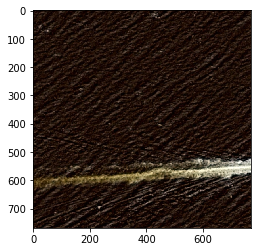

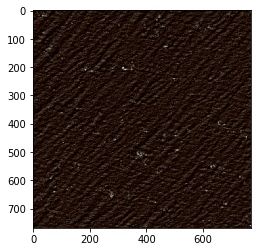

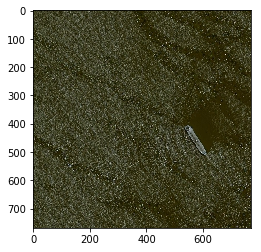

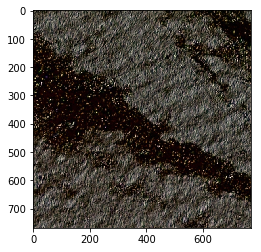

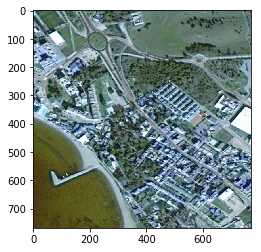

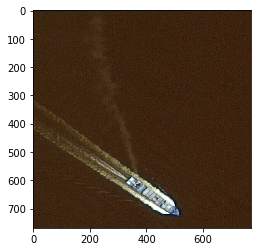

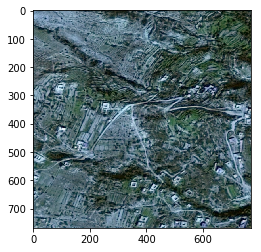

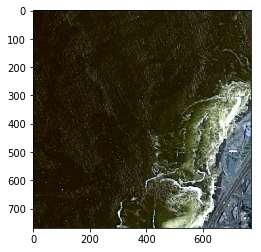

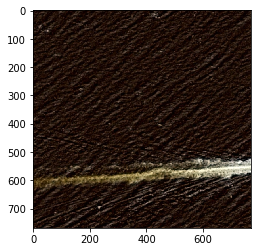

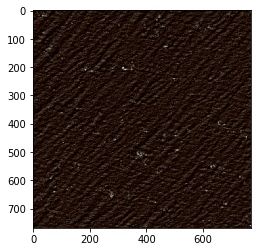

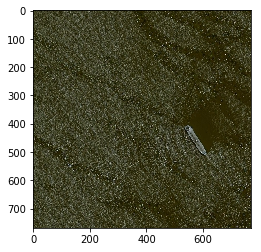

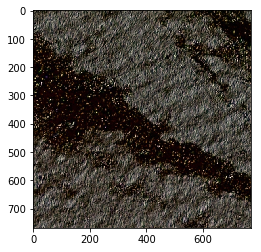

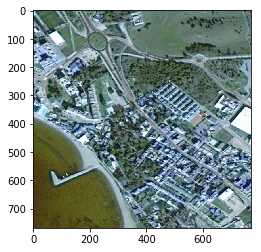

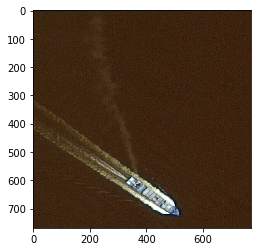

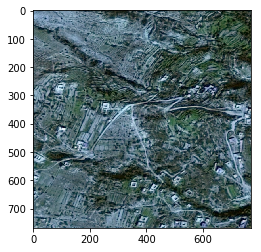

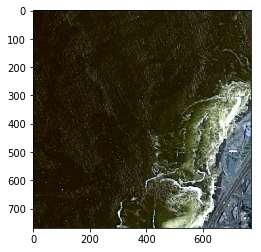

In [32]:
t = 0

for i in range(len(Saved_prediction)):
    if Saved_prediction[i] == 1:
        plt.imshow(cv.imread(test_files[i]))
        plt.show()
        